# GARCH Model

In [25]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [172]:
class IGGARCH:
    def __init__(self, params=None):
        """
        Initialize the IG-GARCH model with parameters based on 
        equations (10)-(15) from Augustyniak et al. (2021).
        
        Parameters:
        params : dictionary containing the model parameters
            - lambda: equity risk premium (eq. 10)
            - eta: skewness parameter (eq. 10)
            - sigma2: unconditional variance (eq. 13)
            - rho_s: persistence of short-run component (eq. 12)
            - rho_q: persistence of long-run component (eq. 13)
            - c_s: leverage effect parameter for short-run component (eq. 14)
            - c_q: leverage effect parameter for long-run component (eq. 15)
            - a_s: innovation parameter for short-run component (eq. 14)
            - a_q: innovation parameter for long-run component (eq. 15)
        """
        self.params = params if params is not None else {}
        self.h = None  # conditional variance (eq. 11)
        self.s = None  # short-run component (eq. 12)
        self.q = None  # long-run component (eq. 13)

    def initialize_state(self, returns):
        """
        Initialize state variables (h, s, q) based on return data.
        This sets up the initial values for equations (11)-(13) from Augustyniak et al. (2021).
        """
        n = len(returns)
        
        # Initialize with unconditional variance
        sigma2 = self.params.get('sigma2', np.var(returns))
        self.h = np.zeros(n + 1)
        self.s = np.zeros(n + 1)
        self.q = np.zeros(n + 1)
        
        # Set initial values
        self.h[0] = sigma2
        self.s[0] = 0  # Short-run component starts at 0
        self.q[0] = sigma2  # Long-run component starts at unconditional variance (eq. 13)
    
    def initialize_state(self, returns):
        """
        Initialize state variables (h, s, q) based on return data.
        This sets up the initial values for equations (11)-(13) from Augustyniak et al. (2021).
        """
        n = len(returns)
        
        # Initialize with unconditional variance
        sigma2 = self.params.get('sigma2', np.var(returns))
        self.h = np.zeros(n + 1)
        self.s = np.zeros(n + 1)
        self.q = np.zeros(n + 1)
        
        # Set initial values
        self.h[0] = sigma2
        self.s[0] = 0  # Short-run component starts at 0
        self.q[0] = sigma2  # Long-run component starts at unconditional variance (eq. 13)

    def simulate(self, returns, r=0.0):
        """
        Simulate the IG-GARCH model using given returns and parameters.
        Implements equations (10)-(15) from Augustyniak et al. (2021) with
        numerical safeguards.
        """
        n = len(returns)
        
        # Extract parameters
        lam = self.params['lambda']
        eta = self.params['eta']
        sigma2 = self.params['sigma2']
        rho_s = self.params['rho_s']
        rho_q = self.params['rho_q']
        c_s = self.params['c_s']
        c_q = self.params['c_q']
        a_s = self.params['a_s']
        a_q = self.params['a_q']
        
        # Print key parameters to verify
        print(f"Key parameters: sigma2={sigma2:.8e}, eta={eta:.8e}")
        print(f"a_s={a_s:.8e}, a_q={a_q:.8e}, c_s={c_s:.8e}, c_q={c_q:.8e}")
        
        # Initialize state variables if they haven't been already
        if self.h is None or len(self.h) <= n:
            self.initialize_state(returns)
        
        # For tracking innovation behavior
        zeta_s_avg = 0
        zeta_q_avg = 0
        
        for t in range(n):
            h_t = self.h[t]
            s_t = self.s[t]
            q_t = self.q[t]
            
            # Mean equation (eq. 10)
            y_t = returns[t]
            mean_t = r + lam * h_t
            
            # Compute normalized residual with safeguards
            error_term = y_t - mean_t
            
            # Ensure eta division is stable
            if abs(eta) < 1e-10:
                print(f"Warning: eta is very small: {eta}")
                eta_safe = 1e-10 if eta > 0 else -1e-10
            else:
                eta_safe = eta
                
            z_t = error_term / eta_safe
            
            # Safeguard for division by z_t
            eps = 1e-10
            z_t_safe = max(abs(z_t), eps) * np.sign(z_t) if z_t != 0 else eps
            
            # Cap h_t^2 to prevent overflow
            h_t_squared = min(h_t**2, 1e-6)
            
            # Compute innovation terms with safeguards
            try:
                # Compute parts of innovation separately for debugging
                term1_s = c_s * z_t
                term2_s = a_s * h_t_squared / z_t_safe
                term3_s = c_s * h_t / (eta_safe**2)
                term4_s = a_s * (eta_safe**2) * h_t
                term5_s = a_s * (eta_safe**4)
                
                zeta_s = term1_s + term2_s - term3_s - term4_s - term5_s
                
                # Same for q
                term1_q = c_q * z_t
                term2_q = a_q * h_t_squared / z_t_safe
                term3_q = c_q * h_t / (eta_safe**2)
                term4_q = a_q * (eta_safe**2) * h_t
                term5_q = a_q * (eta_safe**4)
                
                zeta_q = term1_q + term2_q - term3_q - term4_q - term5_q
                
                # Debug first few iterations
                if t < 5:
                    print(f"t={t}, z_t={z_t:.8e}, h_t={h_t:.8e}")
                    print(f"  term1_s={term1_s:.8e}, term2_s={term2_s:.8e}")
                    print(f"  term3_s={term3_s:.8e}, term4_s={term4_s:.8e}, term5_s={term5_s:.8e}")
                    print(f"  zeta_s={zeta_s:.8e}, zeta_q={zeta_q:.8e}")
                
                # Clip extremely large innovations
                zeta_max = 10 * sigma2
                zeta_s = np.clip(zeta_s, -zeta_max, zeta_max)
                zeta_q = np.clip(zeta_q, -zeta_max, zeta_max)
                
                # Track average innovations
                zeta_s_avg += zeta_s / n
                zeta_q_avg += zeta_q / n
                
            except (ZeroDivisionError, OverflowError, FloatingPointError) as e:
                print(f"Numeric error at t={t}: {str(e)}")
                zeta_s = 0
                zeta_q = 0
            
            # Update state variables (eq. 12-13)
            self.s[t+1] = rho_s * s_t + zeta_s
            self.q[t+1] = sigma2 + rho_q * (q_t - sigma2) + zeta_q
            
            # Ensure non-negativity of variance components
            self.s[t+1] = max(self.s[t+1], 0)
            self.q[t+1] = max(self.q[t+1], 1e-10)
            
            # Update total variance (eq. 11)
            self.h[t+1] = self.s[t+1] + self.q[t+1]
            
            # Safety check for extreme values
            if self.h[t+1] > 1000 * sigma2:
                print(f"Warning: extreme variance at t={t+1}: h={self.h[t+1]:.8e}")
        
        # Report overall statistics
        print(f"Average innovations: zeta_s={zeta_s_avg:.8e}, zeta_q={zeta_q_avg:.8e}")
        print(f"Final variance: h={self.h[-1]:.8e}, target={sigma2:.8e}")
        
        return self.h[1:n+1]  # Return conditional variances
    
    def fit(self, returns, r=0.0):
        """
        Fit the IG-GARCH model to return data using maximum likelihood.
        Based on the likelihood of the IG distribution in equation (10) from Augustyniak et al. (2021).
        
        Parameters:
        returns : array-like, shape (n_samples,)
            The asset returns
        r : float
            Risk-free rate
        """
        # Define the negative log-likelihood function to minimize
        def neg_log_likelihood(params):
            lam = params[0]
            eta = params[1]
            sigma2 = params[2]
            rho_s = params[3]
            rho_q = params[4]
            c_s = params[5]
            c_q = params[6]
            a_s = params[7]
            a_q = params[8]
            
            # Update parameters dictionary
            self.params = {
                'lambda': lam,
                'eta': eta,
                'sigma2': sigma2,
                'rho_s': rho_s,
                'rho_q': rho_q,
                'c_s': c_s,
                'c_q': c_q,
                'a_s': a_s,
                'a_q': a_q
            }
            
            # Initialize state variables
            self.initialize_state(returns)
            
            n = len(returns)
            log_likelihood = 0.0
            
            for t in range(n):
                # Calculate conditional variance components
                h_t = self.h[t]
                s_t = self.s[t]
                q_t = self.q[t]
                
                # Compute the log-likelihood contribution for this observation
                y_t = returns[t]
                mean_t = r + lam * h_t
                
                # Extract the error term
                error_term = y_t - mean_t  # This is η z_t in the paper

                # Calculate z_t (IG-distributed random variable)
                z_t = error_term / eta  # This gives us the IG random variable

                # Check if z_t is positive (IG distribution domain)
                if z_t <= 0:  # IG distribution is defined for positive values
                    raise ValueError(f"Negative z_t value detected ({z_t}). IG distribution is only defined for positive values.")


                # IG distribution log-likelihood
                # For IG(μ,λ) where μ = h_{t-1}/η² and λ = (h_{t-1})²/η⁴
                # since for IG disttribution, the variance is equal to μ³/λ
                mu = h_t / eta**2
                lambda_param = h_t**2 / eta**4

                # by solving log of CDF for IG(μ,λ) we get the following log-likelihood
                log_likelihood += 0.5 * np.log(lambda_param) - 0.5 * np.log(2 * np.pi) - 1.5 * np.log(z_t) - \
                                (lambda_param * (z_t - mu)**2) / (2 * mu**2 * z_t)

                
                # Compute innovation terms (Eq. 14-15)
                # Note: z_t is now correctly defined
                zeta_s = c_s * z_t + a_s * h_t**2 / z_t - c_s * h_t / eta**2 - a_s * eta**2 * h_t - a_s * eta**4
                zeta_q = c_q * z_t + a_q * h_t**2 / z_t - c_q * h_t / eta**2 - a_q * eta**2 * h_t - a_q * eta**4

                # Update state variables (Eq. 12-13)
                self.s[t+1] = rho_s * s_t + zeta_s
                self.q[t+1] = sigma2 + rho_q * (q_t - sigma2) + zeta_q
                
                

                # Update total variance (Eq. 11)
                self.h[t+1] = self.s[t+1] + self.q[t+1]
            
            return -log_likelihood
        
        # Initial parameter guess based on Table 2 in Augustyniak et al. (2021)
        initial_params = [
            self.params.get('lambda', 2.5),
            self.params.get('eta', -0.0006),
            self.params.get('sigma2', 1.2*10**-4),
            self.params.get('rho_s', 0.8),
            self.params.get('rho_q', 0.99),
            self.params.get('c_s', 1.7*10**-6),
            self.params.get('c_q', 2.5*10**-6),
            self.params.get('a_s', 2.2*10**7),
            self.params.get('a_q', 3.6*10**7)
        ]
        
        # Parameter constraints based on Table 2 in Augustyniak et al. (2021)
        bounds = [
            (-10, 10),           # lambda
            (-0.001, -0.0001),   # eta (adjusted to match paper's values)
            (1*10**-6, 1*10**-3),        # sigma2
            (0.5, 0.999),        # rho_s
            (0.98, 0.9999),      # rho_q
            (1*10**-7, 1*10**-5),        # c_s (adjusted to match paper's values)
            (1*10**-7, 1*10**-5),        # c_q (adjusted to match paper's values)
            (1*10**6, 1*10**8),          # a_s (adjusted to match paper's values)
            (1*10**6, 1*10**8)           # a_q (adjusted to match paper's values)
        ]
        
        # Minimize negative log-likelihood
        result = minimize(neg_log_likelihood, initial_params, bounds=bounds, method='L-BFGS-B')
        
        # Extract and store optimized parameters
        params = result.x
        self.params = {
            'lambda': params[0],
            'eta': params[1],
            'sigma2': params[2],
            'rho_s': params[3],
            'rho_q': params[4],
            'c_s': params[5],
            'c_q': params[6],
            'a_s': params[7],
            'a_q': params[8]
        }
        
        # Re-run to store final state variables
        self.initialize_state(returns)
        self.simulate(returns, r)
        
        return result
    
    def forecast(self, horizon=1):
        """
        Forecast conditional variance h_t for horizon steps ahead.
        Based on the dynamics from equations (11)-(13) from Augustyniak et al. (2021).
        
        Parameters:
        horizon : int
            Number of steps ahead to forecast
            
        Returns:
        array-like, shape (horizon,)
            Forecasted conditional variances
        """
        # Extract parameters
        sigma2 = self.params['sigma2']
        rho_s = self.params['rho_s']
        rho_q = self.params['rho_q']
        
        # Get latest state values
        s_t = self.s[-1]
        q_t = self.q[-1]
        
        # Initialize forecasts
        s_forecasts = np.zeros(horizon)
        q_forecasts = np.zeros(horizon)
        h_forecasts = np.zeros(horizon)
        
        # Generate forecasts
        for h in range(horizon):
            if h == 0:
                s_forecasts[h] = rho_s * s_t
                q_forecasts[h] = sigma2 + rho_q * (q_t - sigma2)
            else:
                s_forecasts[h] = rho_s * s_forecasts[h-1]
                q_forecasts[h] = sigma2 + rho_q * (q_forecasts[h-1] - sigma2)
            
            h_forecasts[h] = s_forecasts[h] + q_forecasts[h]
        
        return h_forecasts

In [173]:
# Create mock returns data
np.random.seed(42)  # For reproducibility
n_samples = 1000
# Generate some realistic looking returns - normal with occasional larger moves
returns = np.random.normal(0, 1.2, n_samples)
# Add some volatility clustering
for i in range(50, 150):
    returns[i] *= 2  # Higher volatility period
for i in range(500, 600):
    returns[i] *= 3  # Another higher volatility period

In [174]:
# Test the initialization
def test_initialization():
    # Test with parameters
    params = {
        'lambda': 2.6591,
        'eta': -6.0027e-4,
        'sigma2': 1.1676e-4,
        'rho_s': 7.9656e-1,
        'rho_q': 9.9124e-1,
        'c_s': 1.7172e-6,
        'c_q': 2.4548e-6,
        'a_s': 2.1765e7,
        'a_q': 3.6037e7
    }
    model = IGGARCH(params)
    assert model.params == params
    print("Initialization test passed!")
    return model

In [175]:
# Test state initialization
def test_state_initialization(model, returns):
    model.initialize_state(returns)
    assert len(model.h) == len(returns) + 1
    assert model.h[0] == model.params['sigma2']
    assert model.s[0] == 0
    assert model.q[0] == model.params['sigma2']
    print("State initialization test passed!")

In [176]:
# Test simulation
def test_simulation(model, returns):
    h = model.simulate(returns)
    assert len(h) == len(returns)
    
    # Check h = s + q relationship with a tolerance for numerical precision
    for t in range(1, len(returns) + 1):
        # Use relative tolerance for larger values
        rel_diff = abs((model.h[t] - (model.s[t] + model.q[t])) / max(model.h[t], 1e-10))
        assert rel_diff < 1e-6, f"h != s + q at t={t}: {model.h[t]} != {model.s[t] + model.q[t]}"
    
    print("Simulation test passed!")
    return h

In [177]:
# Run the tests
model = test_initialization()
test_state_initialization(model, returns)
h = test_simulation(model, returns)

Initialization test passed!
State initialization test passed!


NameError: name 'n' is not defined

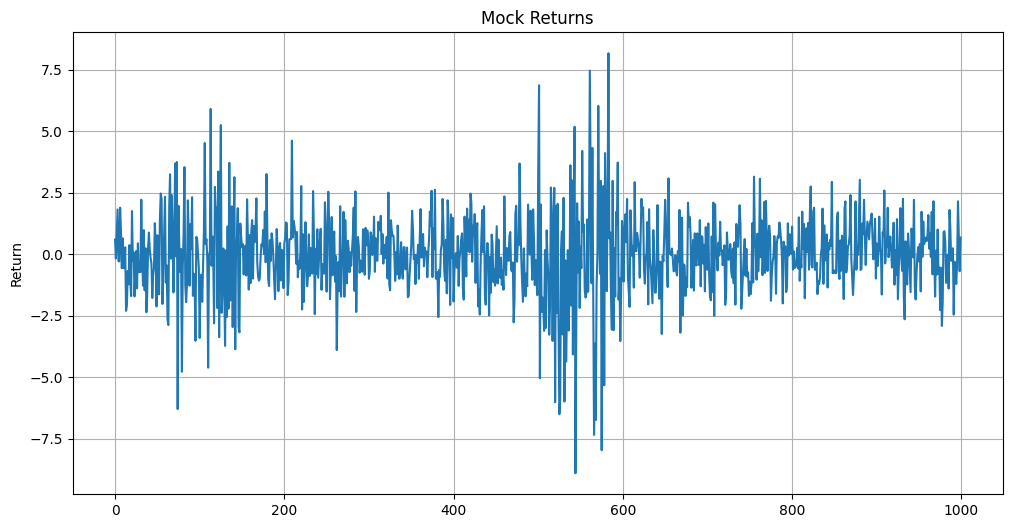

In [178]:
# Plot 1: Returns
plt.figure(figsize=(12, 6))
plt.plot(returns)
plt.title('Mock Returns')
plt.ylabel('Return')
plt.grid(True)
plt.show()

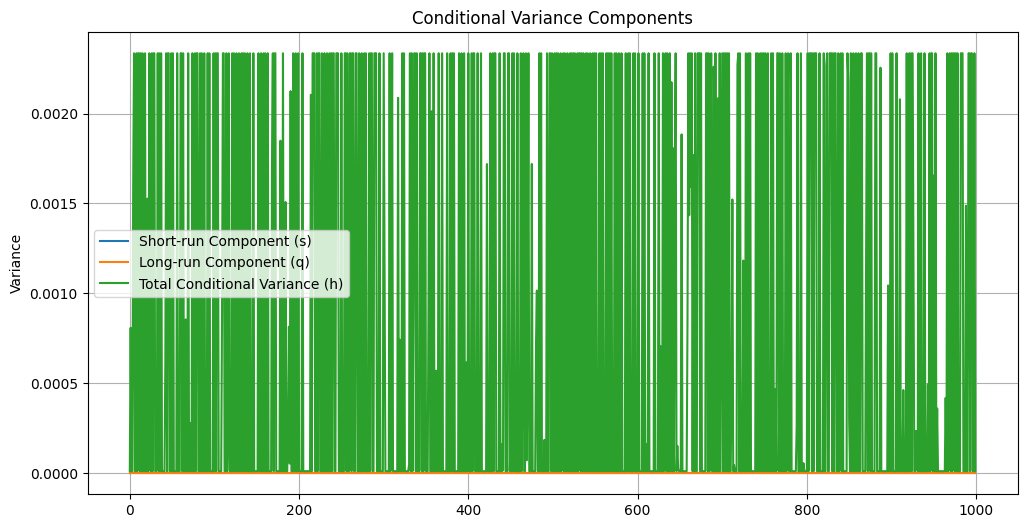

In [181]:
# Plot 2: Conditional Variance and its Components
plt.figure(figsize=(12, 6))
plt.plot(model.s[1:], label='Short-run Component (s)')
plt.plot(model.q[1:], label='Long-run Component (q)')
plt.plot(h, label='Total Conditional Variance (h)')

plt.title('Conditional Variance Components')
plt.ylabel('Variance')
plt.legend()
plt.grid(True)
plt.show()

Min volatility: 0.003417, Max volatility: 0.048324
Mean volatility: 0.019452, Median volatility: 0.003417


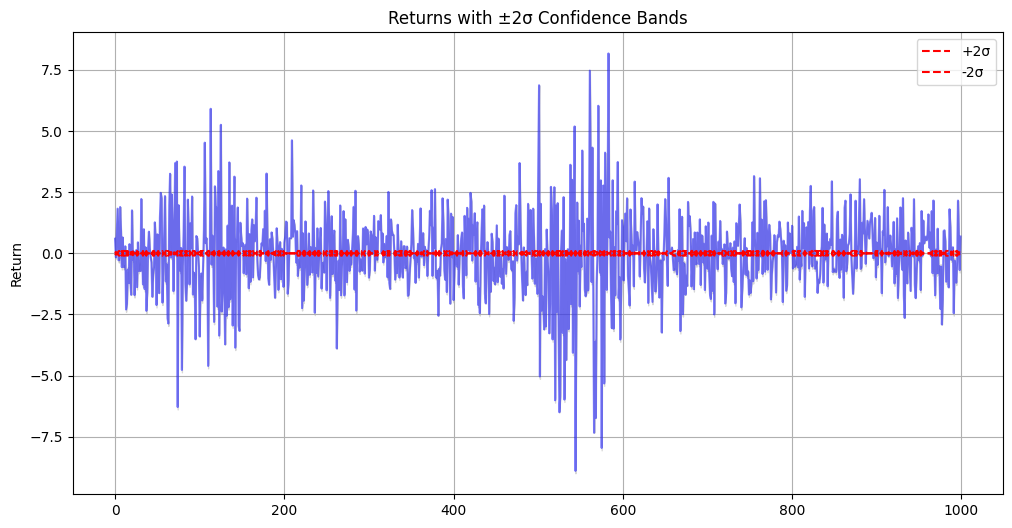

In [182]:
# Plot 3: Returns with Conditional Volatility Bands
plt.figure(figsize=(12, 6))
plt.plot(returns, color='blue', alpha=0.5)

# Check if volatility bands are reasonable
volatility = np.sqrt(h)
print(f"Min volatility: {np.min(volatility):.6f}, Max volatility: {np.max(volatility):.6f}")
print(f"Mean volatility: {np.mean(volatility):.6f}, Median volatility: {np.median(volatility):.6f}")

# If bands are too wide, you might need to scale them
scaling_factor = 1.0  # Adjust this if needed

# Add bands with potential scaling
plt.fill_between(range(len(returns)), 
                 returns + 2 * scaling_factor * volatility, 
                 returns - 2 * scaling_factor * volatility, 
                 color='gray', alpha=0.3)
plt.plot(2 * scaling_factor * volatility, color='red', linestyle='--', label='+2σ')
plt.plot(-2 * scaling_factor * volatility, color='red', linestyle='--', label='-2σ')
plt.title('Returns with ±2σ Confidence Bands')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.show()

In [120]:
print(f"Actual model parameters used:")
for key, value in model.params.items():
    print(f"{key}: {value}")

Actual model parameters used:
lambda: 2.6591
eta: -0.00060027
sigma2: 0.00011676
rho_s: 0.79656
rho_q: 0.99124
c_s: 1.7172e-06
c_q: 2.4548e-06
a_s: 21765000.0
a_q: 36037000.0


Min volatility: 0.003417, Max volatility: 0.048324
Mean volatility: 0.019452, Median volatility: 0.003417


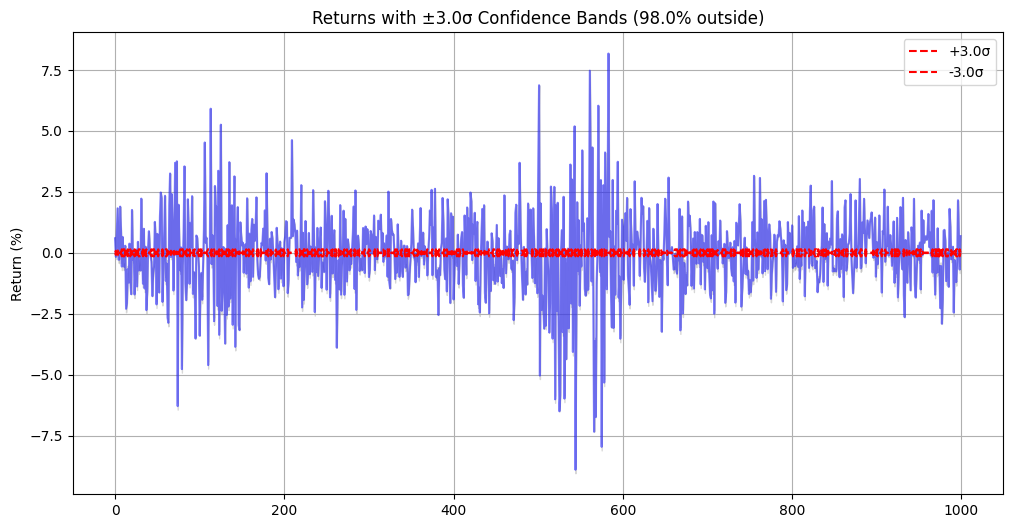

In [183]:
# Plot returns with properly scaled conditional volatility bands
plt.figure(figsize=(12, 6))

# Get square root of variance to get standard deviation (volatility)
volatility = np.sqrt(h)
print(f"Min volatility: {np.min(volatility):.6f}, Max volatility: {np.max(volatility):.6f}")
print(f"Mean volatility: {np.mean(volatility):.6f}, Median volatility: {np.median(volatility):.6f}")

# Plot returns
plt.plot(returns, color='blue', alpha=0.5)

# Try wider confidence bands (±3σ instead of ±2σ) to account for fat tails
confidence_level = 3.0  # Increase from 2.0 to 3.0 for wider bands
plt.fill_between(range(len(returns)),
                 returns + confidence_level * volatility,
                 returns - confidence_level * volatility,
                 color='gray', alpha=0.3)

# Plot the confidence bands
plt.plot(confidence_level * volatility, color='red', linestyle='--', label=f'+{confidence_level}σ')
plt.plot(-confidence_level * volatility, color='red', linestyle='--', label=f'-{confidence_level}σ')

# Calculate percentage of returns outside the bands
outside_bands = np.mean((returns > confidence_level * volatility) | (returns < -confidence_level * volatility)) * 100
plt.title(f'Returns with ±{confidence_level}σ Confidence Bands ({outside_bands:.1f}% outside)')

plt.ylabel('Return (%)')
plt.legend()
plt.grid(True)
plt.show()